In [1]:
%load_ext autoreload
%autoreload 2
import os
#change current working directory to the parent directory
if 'changed' not in globals():
    os.chdir("..")
    os.chdir("..")
    global changed
    changed = True
import numpy as np
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee

In [2]:
config_path = "configs/YEAST_CR/configs_yeast_CR005"
temp_results_path = "temp_results/YEAST_CR/yeast_CR005"  
results_path = "results_csvs/YEAST_CR/yeast_CR005"
apply_thresh = True


In [3]:
#get the name of current folder:
current_folder = os.path.basename(os.getcwd())

In [4]:
config = cl.read_configs(config_path)
nsteps = int(config.get('DEFAULT', 'nsteps'))
npeople = int(config.get('DEFAULT', 'npeople'))
t_end = int(config.get('DEFAULT', 't_end'))
nwalkers = int(config.get('DEFAULT', 'nwalkers'))
nsteps = int(config.get('DEFAULT', 'nsteps'))
num_mcmc_steps = int(config.get('DEFAULT', 'n_mcmc_steps'))
metric = config.get('DEFAULT', 'metric')
time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
data_file = config.get('DEFAULT', 'data_file')
seed_file = config.get('DEFAULT', 'seed_file')
variations = ast.literal_eval(config.get('DEFAULT', 'variations'))
prior = int(config.get('DEFAULT', 'prior'))
transform = bool(config.get('DEFAULT', 'transform'))
index = int(config.get('DEFAULT', 'index'))
submission_folder = config.get(f'SUBMISSION_{index-1}', 'submission_folder')
external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))

#all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
# (remove everything before the current folder name)
data_file = data_file.split(current_folder)[-1]
seed_file = seed_file.split(current_folder)[-1]
submission_folder = submission_folder.split(current_folder)[-1]
#remove the first / from the paths
data_file = data_file[1:]
seed_file = seed_file[1:]
submission_folder = submission_folder[1:]



h5_folder = f"{submission_folder}/h5_files"

In [5]:
ds = dtds.dsFromFile(data_file)
ds.external_hazard = external_hazard
seed_res = rr.readResultsFile(seed_file)
res_df = seed_res[1]
seed = rr.getTheta(res_df)
if transform:
    seed_trans = srmc.transform(seed)

Reading yeast_CR


In [6]:
samples_trans0, lnprobs0 = srmc.loadSamplesFromDir(h5_folder, best=False, thin =5, discard=200)


thresh: -20881.011835687943


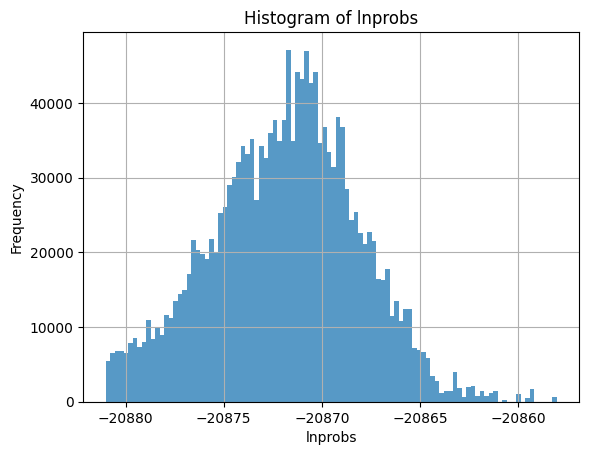

In [7]:
#plot a histogram of lnprobs2
#thresh is the threshold for lnprobs. lnprobs below thresh are not plotted
#thresh is the 95th percentile of lnprobs
thresh = np.percentile(lnprobs0, 27)
print(f"thresh: {thresh}")
# thresh =-np.inf

plt.hist(lnprobs0[lnprobs0>thresh], bins=100, alpha=0.75)
plt.xlabel('lnprobs')
plt.ylabel('Frequency')
plt.title('Histogram of lnprobs')
plt.grid(True)
plt.show()

In [8]:
if apply_thresh:
    samples_trans = samples_trans0[lnprobs0>thresh]
    lnprobs = lnprobs0[lnprobs0>thresh]

In [9]:
print(len(lnprobs))

1642490


In [10]:
sorted_samples_trans = samples_trans[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
p1,p2,p3,p4 = srmc.get_params_from_thetas(sorted_samples_trans)
medians_trans = [np.median(p1),np.median(p2),np.median(p3),np.median(p4)]
means_trans = [np.mean(p1),np.mean(p2),np.mean(p3),np.mean(p4)]
stds_trans = [np.std(p1),np.std(p2),np.std(p3),np.std(p4)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev_trans = [median_abs_deviation(p1),median_abs_deviation(p2),median_abs_deviation(p3),median_abs_deviation(p4)]

In [11]:
samples =np.array([srmc.inv_transform(sample) for sample in samples_trans])

In [12]:
sorted_samples = samples[np.argsort(lnprobs)]
sorted_lnprobs = np.sort(lnprobs)
#get the median values of all the parameters
etas,betas,epsilons,xcs = srmc.get_params_from_thetas(sorted_samples)
medians = [np.median(etas),np.median(betas),np.median(epsilons),np.median(xcs)]
means = [np.mean(etas),np.mean(betas),np.mean(epsilons),np.mean(xcs)]
stds = [np.std(etas),np.std(betas),np.std(epsilons),np.std(xcs)]
#calc the median deviations of the params
from scipy.stats import median_abs_deviation
medev = [median_abs_deviation(etas),median_abs_deviation(betas),median_abs_deviation(epsilons),median_abs_deviation(xcs)]



(16,)


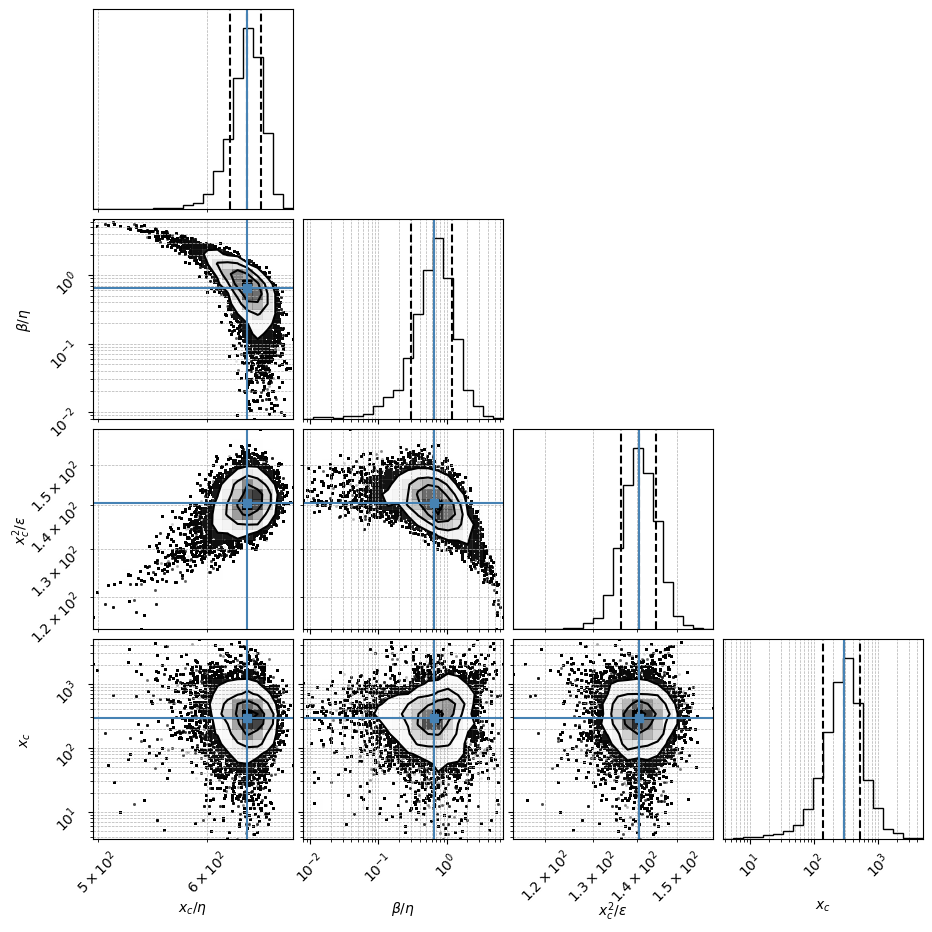

In [13]:
fig = corner.corner(samples_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians_trans)
axes=fig.get_axes()
print(np.shape(axes))
for ax in axes:
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

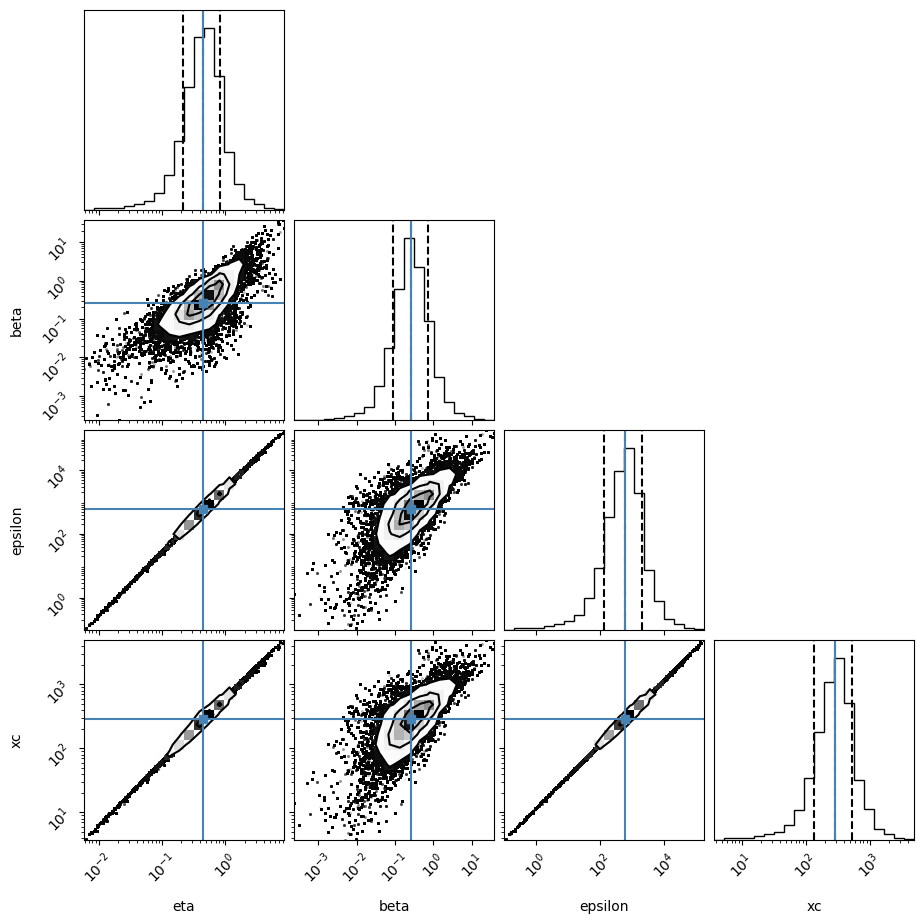

In [14]:
fig = corner.corner(samples, labels=['eta','beta','epsilon','xc'],axes_scale='log',quantiles=[0.16, 0.5, 0.84], truths=medians)

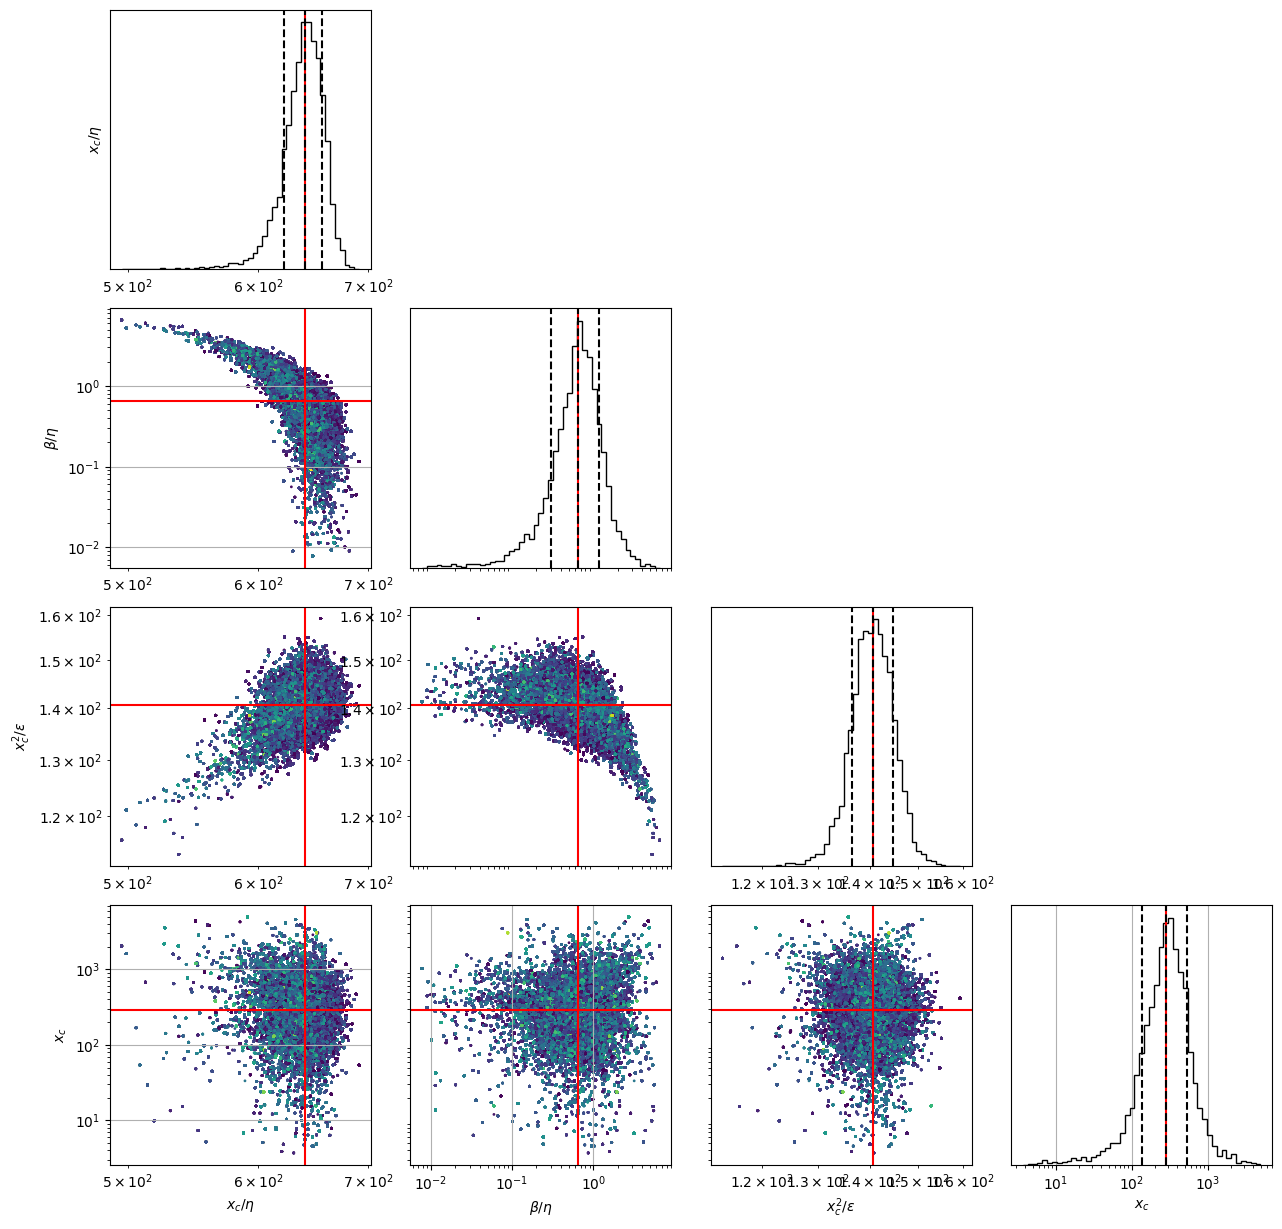

In [15]:
fig,ax=srmc.custom_corner(samples_trans,lnprobs, truths= medians_trans, labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"])

In [16]:

fact=1
import boltsman_stats as bs
dfb = bs.get_stats(samples, lnprobs,ds, file_path=temp_results_path,percent=False)

                            Eta   Beta  Epsilon      Xc  Beta/Eta  Beta*Xc/Eps  Fx=Beta^2/(Eta*Xc)  Dx=Beta*Eps/(Eta*Xc^2)  Xc^2/Eps  Beta*Kappa/Eps  Fk=Beta^2/(Eta*Kappa)  Dk=Beta*Eps/(Eta*Kappa^2)  s=(Xc^1.5*Eta^0.5)/Eps  Slope=Eta*Xc/Eps  Xc/Eps     Fk/Dk       Fk^2/Dk  t_eta  Median Lifetime
Best fit                   0.74  0.068  1549.08  476.44     0.092        0.021            0.000013                 0.00063    146.53        0.000022                  0.013                     571.80                    5.76            0.2300    0.31  0.000022  2.800000e-07  25.42            27.00
Median                     0.45  0.260   585.38  287.39     0.650        0.140            0.000660                 0.00460    140.60        0.000250                  0.320                    1299.44                    5.55            0.2200    0.49  0.000250  9.400000e-05  25.31            27.00
Mean                       0.57  0.510  1760.23  362.59     0.770        0.170            0.001500           

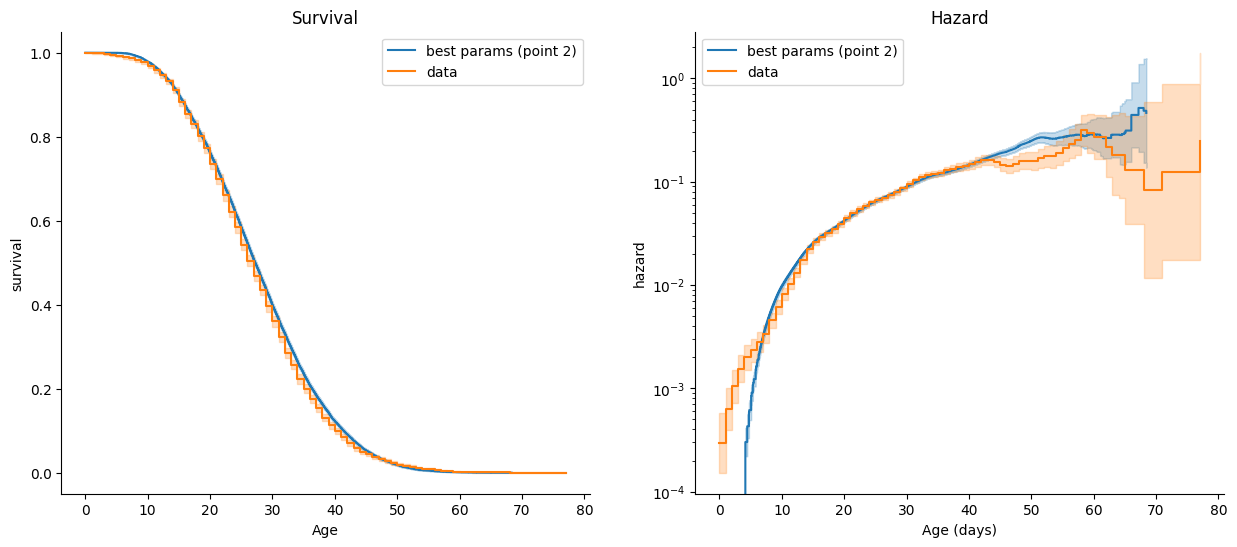

In [17]:
best_theta = sorted_samples[-1]
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

best_sim = srmc.getSr(best_theta, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard,parallel=True)


# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params (point 2)', title='Survival', xlabel='time [years]', ylabel='survival')
ds.plotSurvival(ax=ax0, time_range=time_range,label='data')

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params (point 2)')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

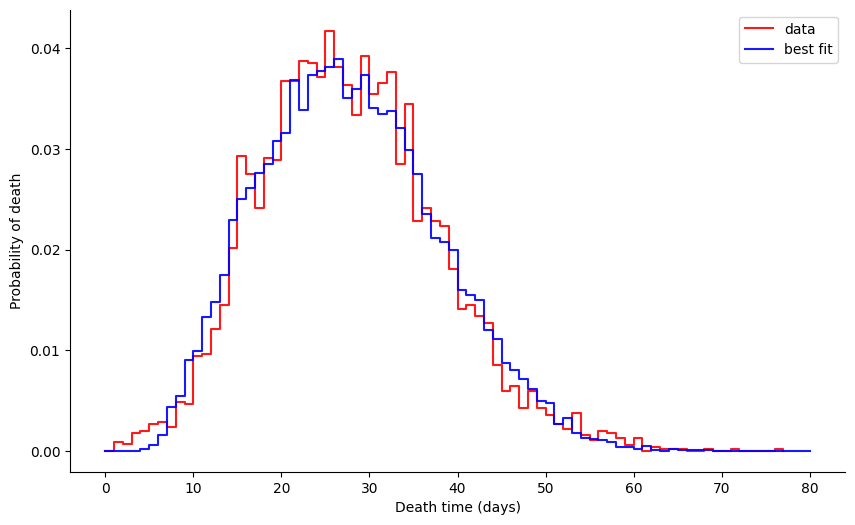

In [18]:
#add plots of the death time distributions of the best fit and data:
fig,ax = plt.subplots(1,1, figsize=(10,6))
use_kde =False
ds.plotDeathTimesDistribution(ax=ax,use_kde=use_kde ,label='data', color='r',alpha=0.9)
best_sim.plotDeathTimesDistribution(ax=ax,use_kde=use_kde, label='best fit', color='b',alpha=0.9)
ax.legend()


Averaging log-probabilities: 100%|██████████| 12724/12724 [00:00<00:00, 377564.21it/s]


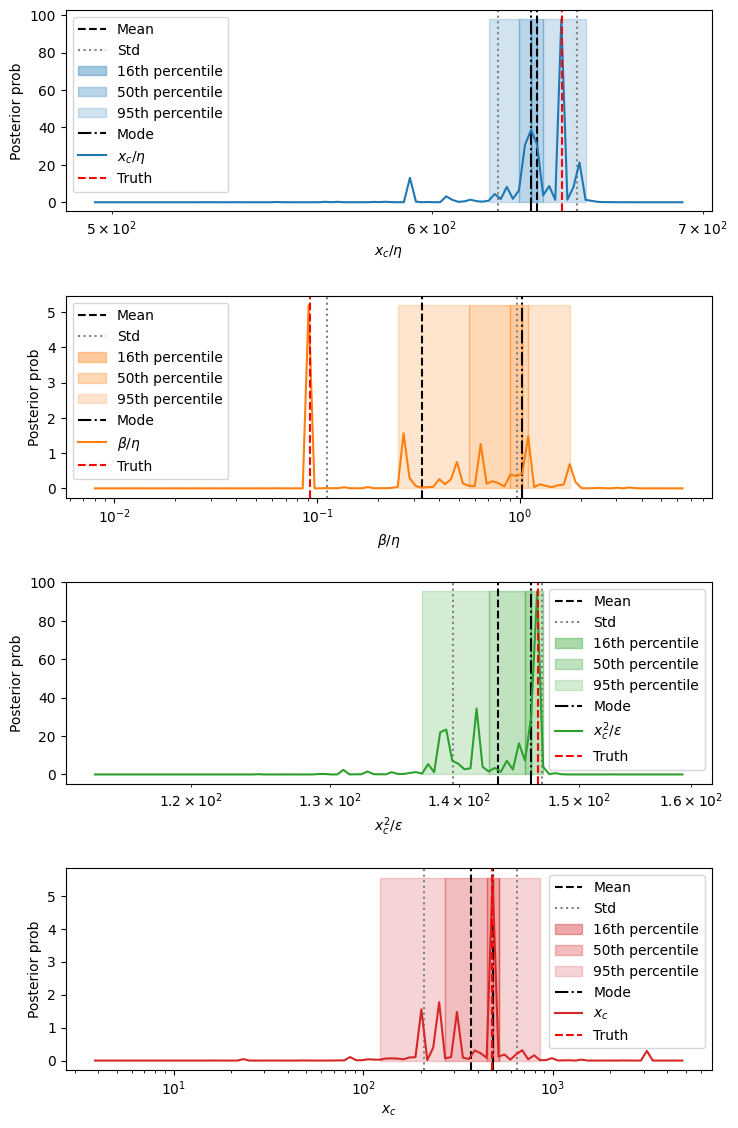

In [19]:
import samples_utils as su

post = su.Posterior(samples_trans, lnprobs, 100, log=True)
post.plot_1d_posteriors(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log')

Creating corner plot:   0%|          | 0/4 [00:00<?, ?it/s]/Volumes/alon/navehr/baysian01/samples_utils.py:618: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X, Y, Z, **kwargs)
Creating corner plot: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


array([[<Axes: xlabel='$x_c/\\eta$', ylabel='Posterior prob'>, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$\\beta/\\eta$'>,
        <Axes: xlabel='$\\beta/\\eta$', ylabel='Posterior prob'>,
        <Axes: >, <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c^2/\\epsilon$'>,
        <Axes: xlabel='$x_c^2/\\epsilon$', ylabel='Posterior prob'>,
        <Axes: >],
       [<Axes: title={'center': '2D Posterior'}, xlabel='$x_c/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$\\beta/\\eta$', ylabel='$x_c$'>,
        <Axes: title={'center': '2D Posterior'}, xlabel='$x_c^2/\\epsilon$', ylabel='$x_c$'>,
        <Axes: xlabel='$x_c$', ylabel='Posterior prob'>]], dtype=object)

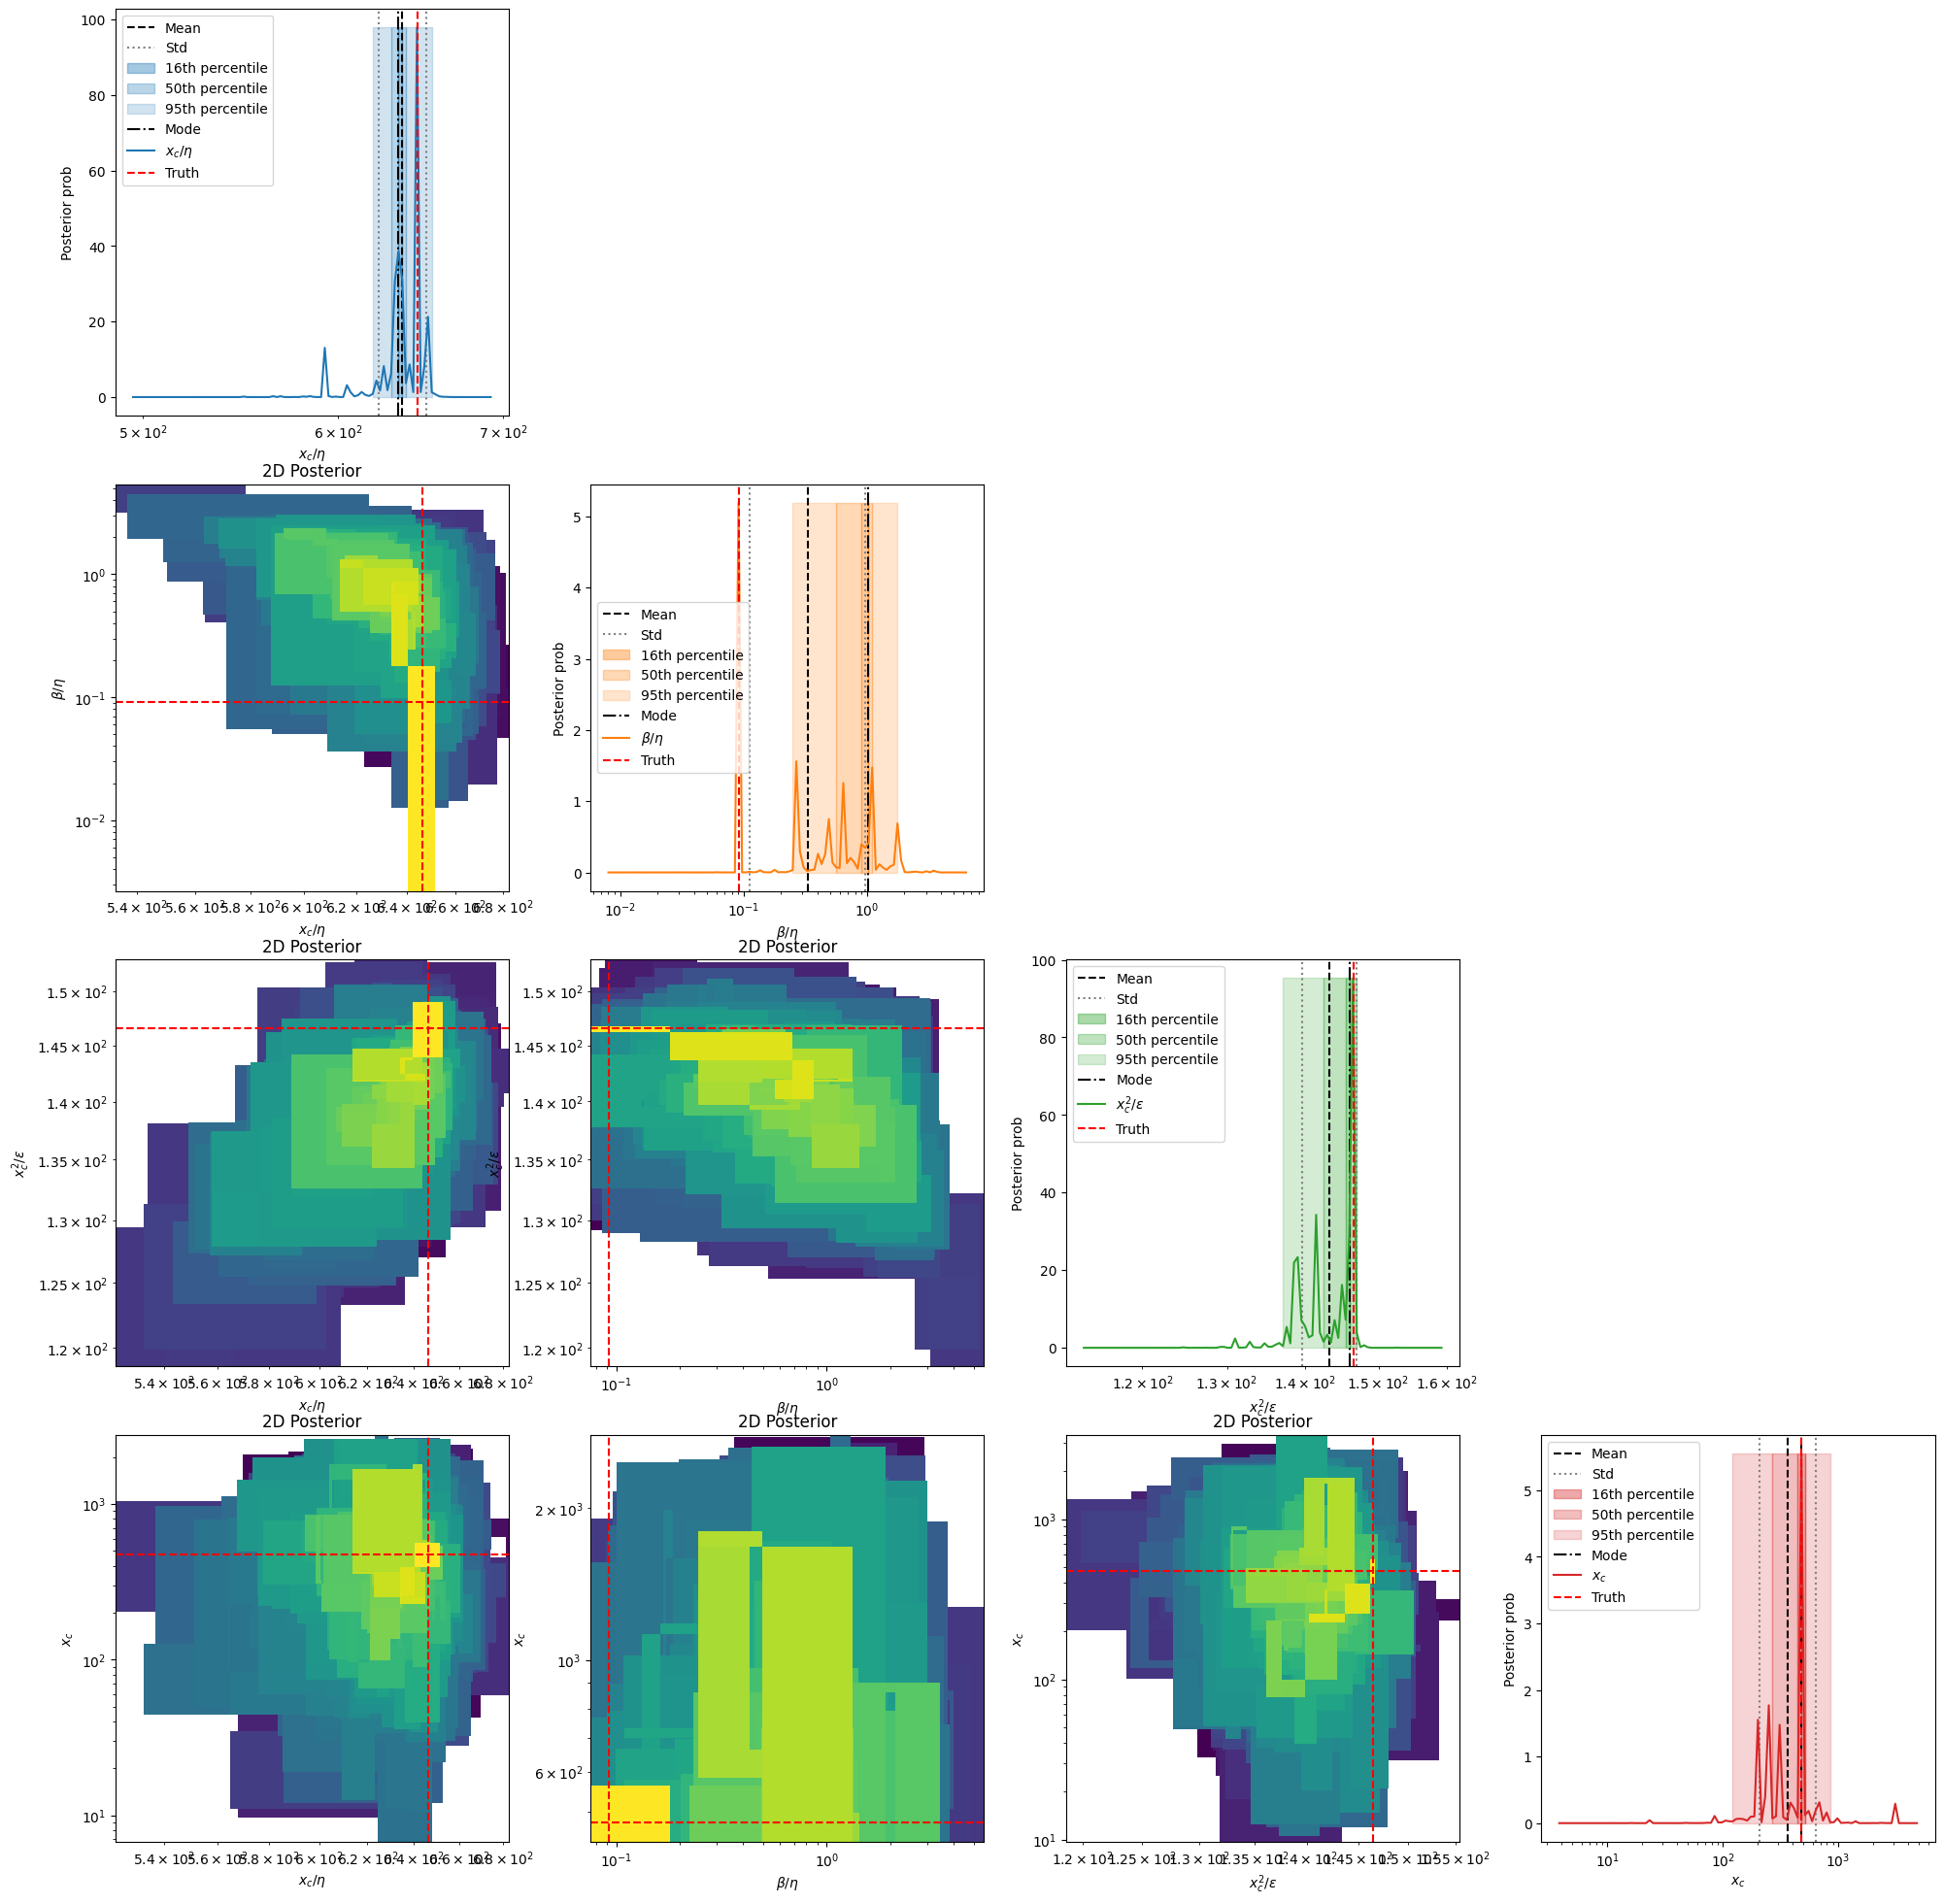

In [20]:
post.corner_plot(labels=["$x_c/\\eta$","$\\beta/\\eta$","$x_c^2/\\epsilon$","$x_c$"], truths=sorted_samples_trans[-1],scale='log',show_ln_prob=False,norm='log',plot_type="pcolormesh")

In [22]:
# df=post.create_posterior_df(filepath=results_path+'_days', ds = [best_sim,ds], ds_labels=['best fit','data'],rescale=365)
df=post.create_posterior_df(filepath=results_path, ds = [best_sim,ds], ds_labels=['best fit','data'])

Averaging log-probabilities: 100%|██████████| 5076/5076 [00:00<00:00, 305377.19it/s]


In [23]:
df

,mean,std,mode,percentile_16,percentile_50,percentile_95,max_likelihood
xc/eta,637.126,"[14.523, 14.199]",645.901,"[645.901, 645.901]","[637.055, 652.616]","[592.562, 666.256]",646.3
beta/eta,0.33,"[0.638, 0.217]",0.0908,"[0.0908, 0.0908]","[0.0908, 0.49]","[0.0908, 1.765]",0.0923
xc^2/epsilon,143.179,"[3.713, 3.619]",146.45,"[146.45, 146.45]","[142.921, 146.961]","[137.547, 146.961]",146.533
xc,367.583,"[276.972, 157.954]",479.645,"[479.645, 479.645]","[250.784, 553.99]","[105.635, 985.895]",476.437
eta,1.23,"[4.055, 0.944]",4.519,"[4.519, 4.519]","[0.79, 4.519]","[0.0401, 5.62]",0.737
beta,0.358,"[0.752, 0.243]",0.422,"[0.422, 0.422]","[0.143, 0.866]","[0.013, 4.646]",0.068
epsilon,4279.482,"[77218.893, 4054.766]",61701.952,"[61701.952, 61701.952]","[1668.548, 61701.952]","[4.476, 61701.952]",1549.084
sqrt(xc/eta),25.24,"[0.285, 0.282]",25.415,"[25.415, 25.415]","[25.24, 25.59]","[24.343, 25.812]",25.422
s= eta^0.5*xc^1.5/epsilon,5.671,"[0.114, 0.111]",5.761,"[5.761, 5.761]","[5.664, 5.803]","[5.462, 5.803]",5.764
beta*xc/epsilon,0.0747,"[0.144, 0.0492]",0.0203,"[0.0203, 0.0203]","[0.0189, 0.111]","[0.0189, 0.406]",0.0209


In [24]:
#get the theta of the modes of the posterior (from the df) location of indexes eta, beta, epsilon, xc and columen 'mode'
theta_mode =  df.loc[['eta','beta','epsilon','xc'],'mode'].values
print(f"theta_mode: {theta_mode}")
theta_mode_trans = df.loc[['xc/eta','beta/eta','xc^2/epsilon','xc'],'mode'].values
print(f"theta_mode_trans: {theta_mode_trans}")
sim_mode = srmc.getSr(theta_mode, nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)
sim_mode_trans = srmc.getSr(srmc.inv_transform(theta_mode_trans), nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard)


theta_mode: [4.519 0.422 61701.952 479.645]
theta_mode_trans: [645.901 0.0908 146.45 479.645]


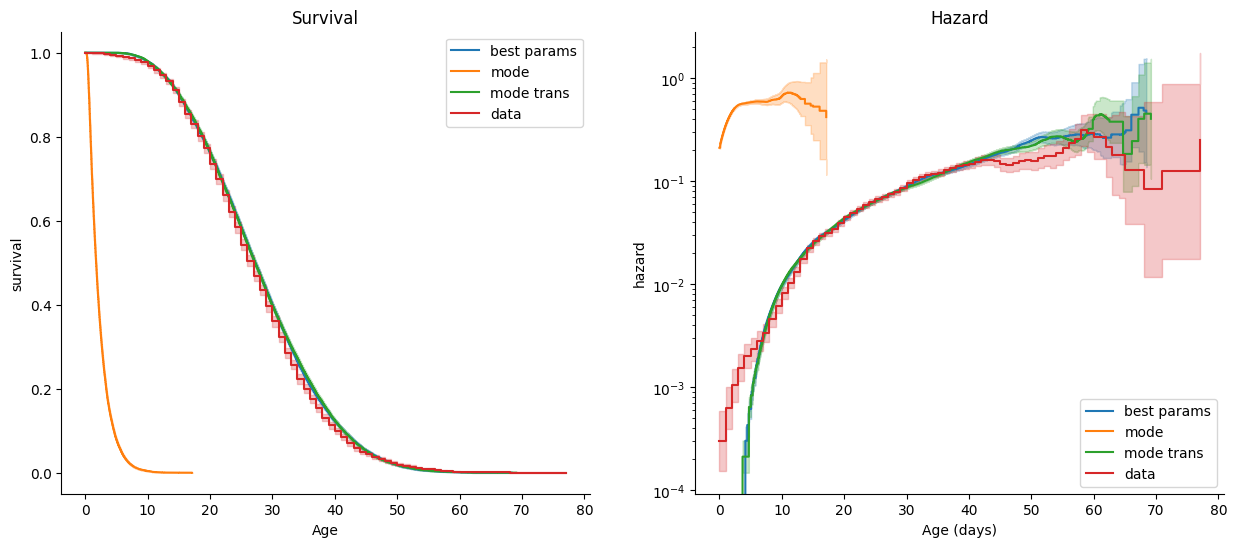

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot survival on ax[0]
ax0 = best_sim.plotSurvival(ax=axs[0],time_range=time_range, label='best params', title='Survival', xlabel='time [years]', ylabel='survival')
sim_mode.plotSurvival(ax=ax0,time_range=time_range, label='mode')
sim_mode_trans.plotSurvival(ax=ax0,time_range=time_range, label='mode trans')
ds.plotSurvival(ax=ax0,time_range=time_range, label='data')
ax0.legend()

# Plot hazard on ax[1]
ax1 = best_sim.plotHazard(ax=axs[1], title='Hazard', xlabel='time [years]', ylabel='hazard', label='best params')
sim_mode.plotHazard(ax=ax1, label='mode')
sim_mode_trans.plotHazard(ax=ax1, label='mode trans')
ds.plotHazard(ax=ax1, label='data')
ax1.set_yscale('log')

Averaging log-probabilities: 100%|██████████| 3798/3798 [00:00<00:00, 312315.54it/s]


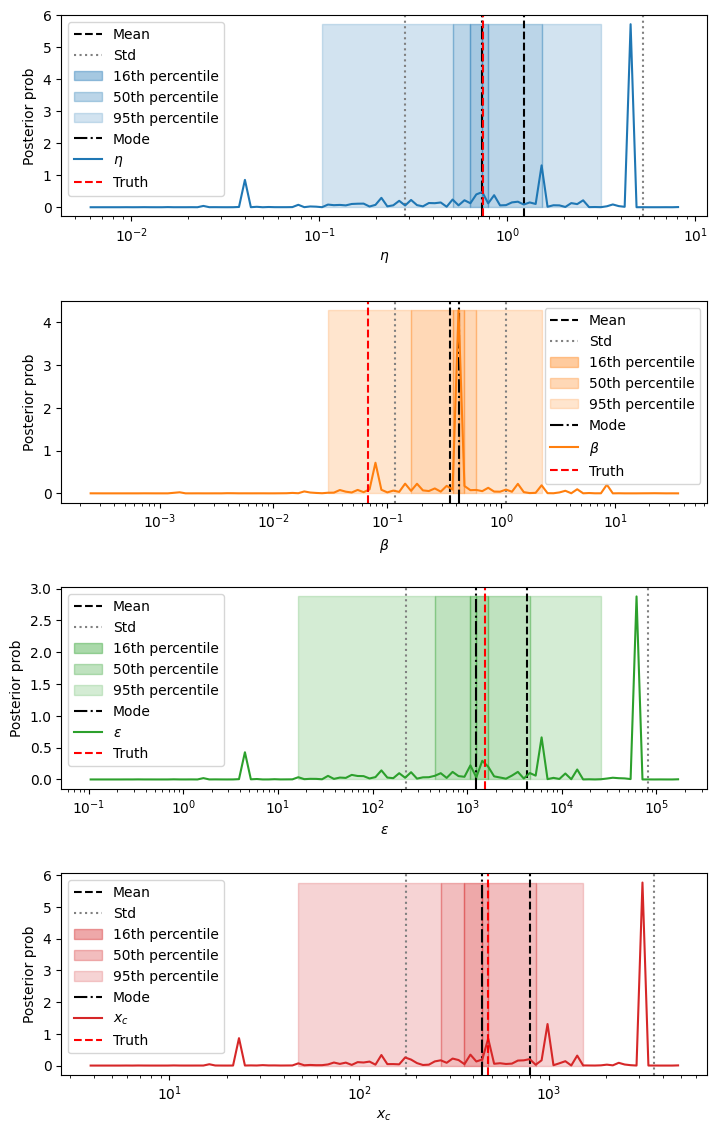

In [26]:
post_regular_params = su.Posterior(samples, lnprobs, 100, log=True)
post_regular_params.plot_1d_posteriors(labels=["$\\eta$","$\\beta$","$\\epsilon$","$x_c$"], truths=sorted_samples[-1],scale='log')